In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re
import string
import spacy
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import time
import scipy.sparse
from gensim import matutils,models
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from nltk import pos_tag
import time
import numpy as np
# import multiprocess as mp
import warnings
warnings.filterwarnings("ignore")

In [12]:
review_df = pd.read_csv("reviews.csv")

In [13]:
review_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [55]:
review_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394956 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      394956 non-null  int64 
 1   productid               394956 non-null  object
 2   userid                  394956 non-null  object
 3   profilename             394956 non-null  object
 4   helpfulnessnumerator    394956 non-null  int64 
 5   helpfulnessdenominator  394956 non-null  int64 
 6   score                   394956 non-null  int64 
 7   time                    394956 non-null  int64 
 8   summary                 394956 non-null  object
 9   text                    394956 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.1+ MB


In [15]:
review_df.columns = review_df.columns.str.strip().str.lower()

In [16]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      568454 non-null  int64 
 1   productid               568454 non-null  object
 2   userid                  568454 non-null  object
 3   profilename             568438 non-null  object
 4   helpfulnessnumerator    568454 non-null  int64 
 5   helpfulnessdenominator  568454 non-null  int64 
 6   score                   568454 non-null  int64 
 7   time                    568454 non-null  int64 
 8   summary                 568427 non-null  object
 9   text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [18]:
review_df.drop_duplicates(subset=['summary', 'text'], inplace=True)
review_df = review_df[review_df['summary'].notna()]
review_df.dropna(inplace=True)
df = review_df[["text", "score"]]

In [19]:
df.head()

,text,score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394956 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            394956 non-null  object
 1   score           394956 non-null  int64 
 2   num_words_text  394956 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 12.1+ MB


Text(0.5, 1.0, 'Histogram of score')

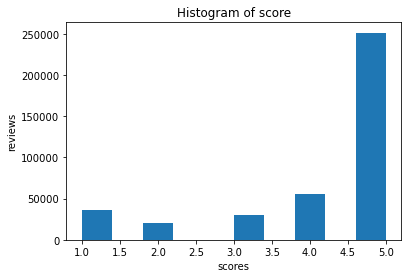

In [61]:
import plotly.express as pt
import matplotlib.pyplot as plt

bins = [1, 2, 3, 4, 5]

plt.hist(review_df["score"])
plt.xlabel('scores')
plt.ylabel('reviews')
plt.title('Histogram of score')

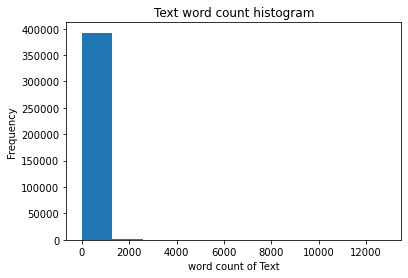

In [60]:
#check length of each reviews
# df["text"].apply(len).hist(bins =30)
# df["text"].apply(len).describe()
df_len = df['text'].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize = (6,4))

plt.hist(df_len, density = False)
plt.title('Text word count histogram')
plt.xlabel('word count of Text')
plt.ylabel('Frequency')
plt.show()

df_len.describe().to_clipboard(excel=True)

<AxesSubplot:xlabel='score', ylabel='num_words_text'>

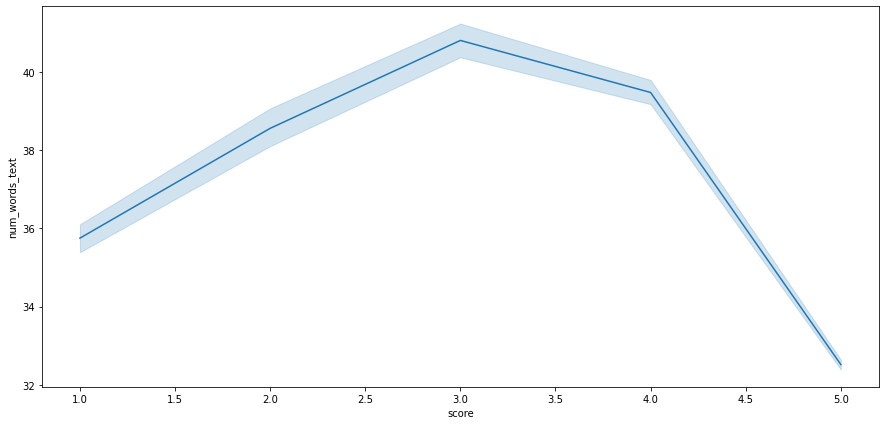

In [65]:
import seaborn as sns
plt.figure(figsize=(15,7))
sns.lineplot(data=df,x="score", y="num_words_text")

Text(0, 0.5, 'Frequency')

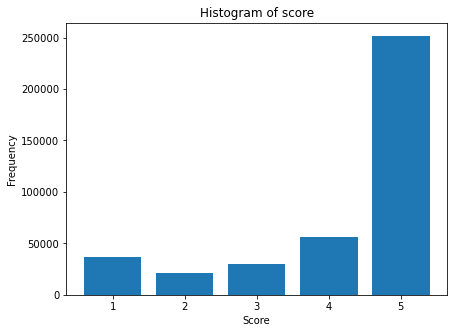

In [71]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
x_ax,word_count = np.unique(df['score'],return_counts=True)
plt.bar([str(i) for i in x_ax],word_count)
plt.title("Histogram of score")
plt.xlabel("Score")
plt.ylabel("Frequency")

In [23]:
key_replace = {"can't": "can not","won't": " will not","n't":" not", "'s":" is","'ve":" have","'re":" are","'ll":" will","'m":" am","'d":" had"}

html_regex = re.compile(r'<[^>]+>')

def remove_tags(text):
    return html_regex.sub('', text)

#delete html tags & replace grammers from text
def clean_review(text):
    text = remove_tags(text)
    for key in key_replace.keys():
        text = text.replace(key,key_replace[key])
    return text

In [24]:
import gensim
from nltk.tokenize import word_tokenize

#function to clean the reviews
def clean_text(text):
    text = text.lower() #lower-casing
    text = clean_review(text)
    text = gensim.parsing.preprocessing.remove_stopwords(text)
    sentence_words = nltk.word_tokenize(text)
    text = [word for word in sentence_words if word.isalpha()]
    text = lemmatization(text) #lemmatizing the reviews
    text = ' '.join(text)
    text = re.sub(r'\d+','',text) #removing numbers
    text = text.translate(str.maketrans('','',string.punctuation)) #removing punctuation
    text = text.strip() #removing white-spaces
    return text

In [25]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

def lemmatization(texts): 
    output = []
    for sent in texts:
        doc = lemmatizer.lemmatize(sent)
        output.append(doc)
    return output

In [26]:
df["text"] = df["text"].apply(clean_text)

In [63]:
df.head().to_clipboard(excel=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394956 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    394956 non-null  object
 1   score   394956 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ MB


In [29]:
df.to_csv("clean_review.csv", encoding='utf-8', index=False)

In [3]:
df = pd.read_csv("clean_review.csv")

In [31]:
df['num_words_text'] = df['text'].apply(lambda x:len(str(x).split())) 

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394956 entries, 0 to 568453
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            394956 non-null  object
 1   score           394956 non-null  int64 
 2   num_words_text  394956 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 12.1+ MB
